## Clone the GutHub Repo

In [1]:
!git clone https://github.com/bhargav-borah/CIFAR10ImageClassification

Cloning into 'CIFAR10ImageClassification'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 89 (delta 13), reused 0 (delta 0), pack-reused 57
Receiving objects: 100% (89/89), 1.44 MiB | 9.91 MiB/s, done.
Resolving deltas: 100% (37/37), done.


## Import the dependencies

In [2]:
!pip install torchinfo

In [3]:
import torch
from torch import nn
import torchvision
from torchvision.transforms import transforms
from torchinfo import summary

import os

## Set up device-agnostic code

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Create train and test dataloaders

In [8]:
os.chdir('CIFAR10ImageClassification/modules')

In [9]:
from data_setup import get_cifar10_dataloaders

In [10]:
data_dir = 'data'

In [11]:
weights = torchvision.models.AlexNet_Weights.DEFAULT
transforms = weights.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [12]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader, test_dataloader, class_names = get_cifar10_dataloaders(data_dir=data_dir,
                                                                         transform=transforms,
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS)

100%|██████████| 170498071/170498071 [00:02<00:00, 64088222.59it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [13]:
image_batch, label_batch = next(iter(train_dataloader))

In [14]:
image_batch[0].shape

torch.Size([3, 224, 224])

In [15]:
model_8 = torchvision.models.alexnet(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 139MB/s]


In [16]:
for param in model_8.parameters():
    param.requires_grad = False

In [17]:
summary(model=model_8,
        input_size=(32, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [32, 3, 224, 224]    [32, 1000]           --                   False
├─Sequential (features)                  [32, 3, 224, 224]    [32, 256, 6, 6]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 55, 55]     (23,296)             False
│    └─ReLU (1)                          [32, 64, 55, 55]     [32, 64, 55, 55]     --                   --
│    └─MaxPool2d (2)                     [32, 64, 55, 55]     [32, 64, 27, 27]     --                   --
│    └─Conv2d (3)                        [32, 64, 27, 27]     [32, 192, 27, 27]    (307,392)            False
│    └─ReLU (4)                          [32, 192, 27, 27]    [32, 192, 27, 27]    --                   --
│    └─MaxPool2d (5)                     [32, 192, 27, 27]    [32, 192, 13, 13]    --                   --
│    └─Conv2d (6) 

In [18]:
model_8.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [24]:
model_8.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features=9216, out_features=4096, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=4096, out_features=len(class_names), bias=True)
).to(device)

In [25]:
summary(model=model_8,
        input_size=(32, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 256, 6, 6]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 55, 55]     (23,296)             False
│    └─ReLU (1)                          [32, 64, 55, 55]     [32, 64, 55, 55]     --                   --
│    └─MaxPool2d (2)                     [32, 64, 55, 55]     [32, 64, 27, 27]     --                   --
│    └─Conv2d (3)                        [32, 64, 27, 27]     [32, 192, 27, 27]    (307,392)            False
│    └─ReLU (4)                          [32, 192, 27, 27]    [32, 192, 27, 27]    --                   --
│    └─MaxPool2d (5)                     [32, 192, 27, 27]    [32, 192, 13, 13]    --                   --
│    └─Conv2d (6

## Train the model

In [26]:
from model_builder import fit

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_8.parameters(),
                             lr=1e-3)

history_8 = fit(model=model_8,
                epochs=10,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Training loss:  0.9827515482902527 | Training accuracy: 0.6728246808052063 | Test loss: 0.6905773282051086 | Test accuracy: 0.7780550718307495
Training loss:  0.7874775528907776 | Training accuracy: 0.7370041608810425 | Test loss: 0.6818135976791382 | Test accuracy: 0.7834464907646179
Training loss:  0.717174232006073 | Training accuracy: 0.7614963054656982 | Test loss: 0.6218388080596924 | Test accuracy: 0.8062100410461426
Training loss:  0.6805391907691956 | Training accuracy: 0.774472177028656 | Test loss: 0.5767688155174255 | Test accuracy: 0.8119009733200073
Training loss:  0.6650916337966919 | Training accuracy: 0.7806301712989807 | Test loss: 0.5405065417289734 | Test accuracy: 0.8211860656738281
Training loss:  0.6265352964401245 | Training accuracy: 0.7909269332885742 | Test loss: 0.555674135684967 | Test accuracy: 0.8165934085845947
Training loss:  0.6140395402908325 | Training accuracy: 0.7962251901626587 | Test loss: 0.5210001468658447 | Test accuracy: 0.8276757001876831
Tr

## Graph out losses and accuracies

In [28]:
from graphing import plot_loss_curves, plot_accuracy_curves

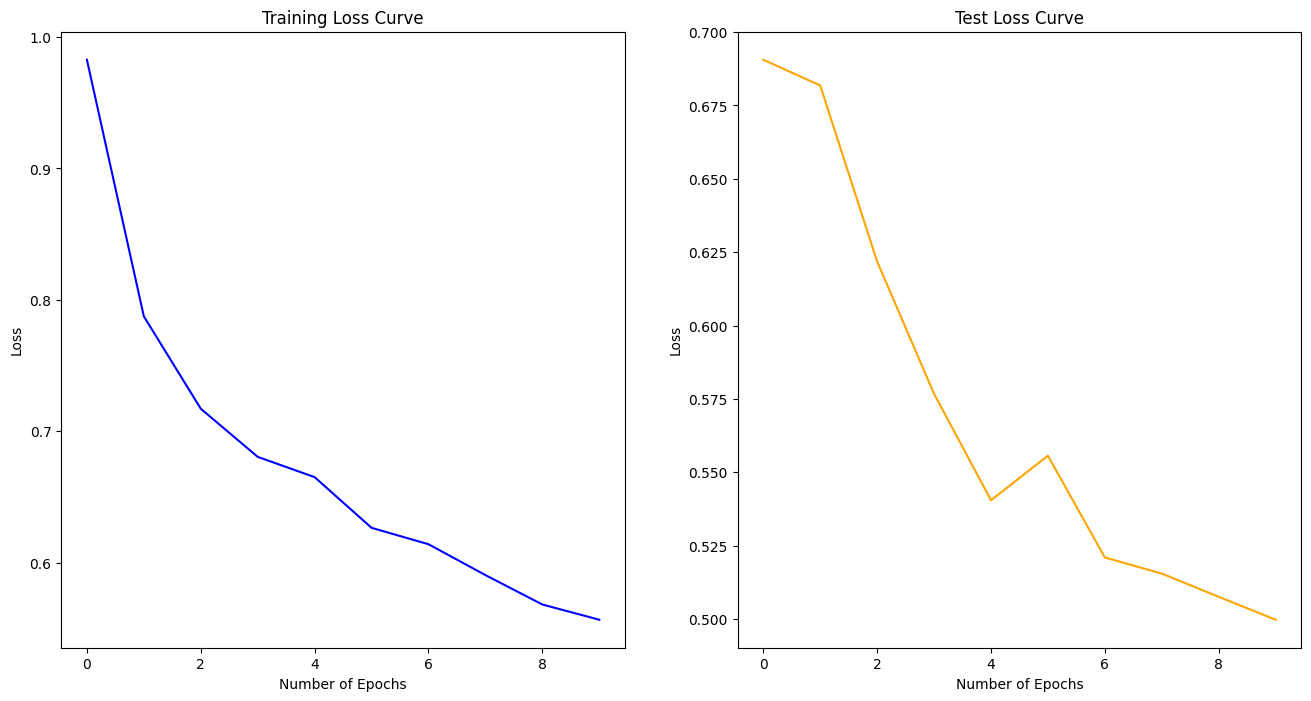

In [29]:
plot_loss_curves(train_losses=history_8['train_losses'],
                 test_losses=history_8['test_losses'])

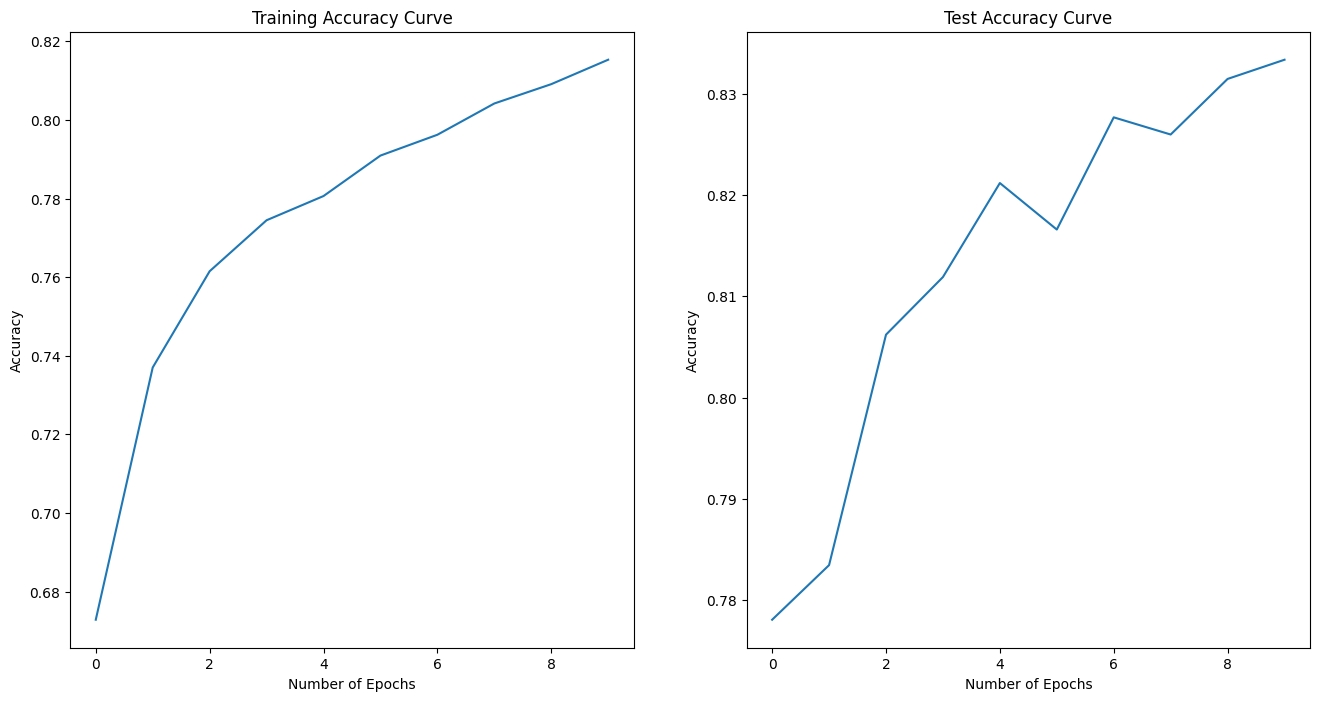

In [30]:
plot_accuracy_curves(train_accuracies=history_8['train_accuracies'],
                     test_accuracies=history_8['test_accuracies'])